In [1]:
import time
import sys
import pandas as pd
import multiprocessing
from functools import reduce
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import json
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal.dynamic_graph_temporal_signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.signal.dynamic_graph_temporal_signal_batch import DynamicGraphTemporalSignalBatch

from torch_geometric_temporal.signal import temporal_signal_split
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

torch.cuda.is_available(), sys.executable

(False, '/Users/koraykinik/miniconda3/envs/ercot/bin/python')

In [2]:
# aws s3 cp s3://myercotdata/ercot_data/processed/dsp_indexed_2024_12_17_22_51_37.parquet.zip .
# aws s3 cp s3://myercotdata/ercot_data/processed/lmp_indexed_2024_12_17_22_51_37.parquet.zip .

In [3]:
###########################
# Read data 
###########################

fp_lmp = r'/Users/koraykinik/PycharmProjects/ercot/data/lmp_indexed_2024_12_17_22_51_37.parquet'
fp_dsp = r'/Users/koraykinik/PycharmProjects/ercot/data/dsp_indexed_2024_12_17_22_51_37.parquet'

df_lmp = pd.read_parquet(fp_lmp, engine='pyarrow')
df_dsp = pd.read_parquet(fp_dsp, engine='pyarrow')

In [4]:
df_lmp.head()

,DeliveryTime_adjusted,SUBSTATION,SUBSTATION_index,LMP,LMP_scaled,DistributionFactor,load,load_scaled,DistributionFactor_scaled,SETTLEMENT_LOAD_ZONE,SETTLEMENT_LOAD_ZONE_index
0,2022-01-02 01:00:00,36POD,0,25.11,-0.181547,0.0,0.000,-0.573728,-0.606036,LZ_WEST,3
1,2022-01-02 01:00:00,89NWK,1,27.97,-0.161821,39.8,1707590.344,0.844185,1.221435,LZ_NORTH,1
2,2022-01-02 01:00:00,A0,2,26.28,-0.173477,33.2,1424422.096,0.609053,0.918387,LZ_SOUTH,2
3,2022-01-02 01:00:00,A4,4,26.25,-0.173684,14.1,604950.348,-0.071402,0.041384,LZ_SOUTH,2
4,2022-01-02 01:00:00,A5,5,26.25,-0.173684,6.1,261716.108,-0.356409,-0.325946,LZ_SOUTH,2


In [5]:
df_dsp.head()

,DeliveryTime_adjusted,FromStation,FromStation_index,ToStation,ToStation_index,ConstraintValue,ConstraintValue_scaled,kV,kV_scaled,ShadowPrice,ShadowPrice_scaled
0,2022-01-02 01:00:00,CONCHO,655,SAMATHIS,2775,38.0,-0.719941,69.0,-0.938807,1.758,-0.228782
1,2022-01-02 01:00:00,NEDIN,2199,NEDIN,2199,569.0,1.090820,345.0,2.631597,2.016,-0.227091
2,2022-01-02 01:00:00,MDLNE,2005,MDLNE,2005,530.0,0.957826,1.0,-1.818471,10.254,-0.173118
3,2022-01-02 01:00:00,SEMINOLE,2849,MAGNO_TN,1925,210.0,-0.133404,138.0,-0.046206,3.515,-0.217270
4,2022-01-02 01:00:00,YELWJCKT,3568,HEXT,1403,30.0,-0.747221,69.0,-0.938807,7.111,-0.193710


In [6]:
##########################
# fix undone filtering by universal substation subset
###########################

dx = df_lmp.groupby('DeliveryTime_adjusted').count()
dx['SUBSTATION_index'].unique()

array([3559, 3569, 3568, 3565, 3567, 3572, 3574, 3575, 3577, 3576, 3578])

In [7]:
sets = df_lmp[['DeliveryTime_adjusted', 'SUBSTATION_index']]\
    .groupby('DeliveryTime_adjusted')\
    .agg(set)['SUBSTATION_index']\
    .to_list()
set([len(s) for s in sets])

{3559, 3565, 3567, 3568, 3569, 3572, 3574, 3575, 3576, 3577, 3578}

In [8]:
from functools import reduce
set_lmp = reduce((lambda x, y: x & y), sets)
len(set_lmp)

3548

In [9]:
df_lmp_filtered = df_lmp[df_lmp['SUBSTATION_index'].isin(set_lmp)]
df_lmp_filtered = df_lmp_filtered\
    .sort_values(by=['DeliveryTime_adjusted', 'SUBSTATION_index'])\
    .reset_index(drop=True)
# df_lmp_filtered.info()

In [10]:
lmp_dt_min = df_lmp_filtered['DeliveryTime_adjusted'].min()
lmp_dt_max = df_lmp_filtered['DeliveryTime_adjusted'].max()

df_dsp_filtered = df_dsp[
    df_dsp['FromStation_index'].isin(set_lmp) 
    & df_dsp['ToStation_index'].isin(set_lmp)
    & df_dsp['DeliveryTime_adjusted'].between(lmp_dt_min, lmp_dt_max)
    ]
df_dsp_filtered = df_dsp_filtered.sort_values(by=['DeliveryTime_adjusted']).reset_index(drop=True)
# df_dsp_filtered.info()

In [11]:
df_lmp_filtered['SUBSTATION_index_2'] = df_lmp_filtered['SUBSTATION'].astype('category').cat.codes.astype(np.int64)
lmp_sub_dict = df_lmp_filtered[['SUBSTATION', 'SUBSTATION_index_2']].set_index('SUBSTATION').to_dict()['SUBSTATION_index_2']

df_dsp_filtered['FromStation_index_2'] = df_dsp_filtered['FromStation'].map(lmp_sub_dict).astype(np.int64)
df_dsp_filtered['ToStation_index_2'] = df_dsp_filtered['ToStation'].map(lmp_sub_dict).astype(np.int64)

In [12]:
###########################
# QC 
###########################

dx = df_lmp_filtered.groupby('DeliveryTime_adjusted').count()
dx['SUBSTATION_index_2'].unique()

array([3548])

In [13]:
df_lmp_filtered['SUBSTATION_index_2'].max()

3547

In [14]:
df_lmp_filtered.head()

,DeliveryTime_adjusted,SUBSTATION,SUBSTATION_index,LMP,LMP_scaled,DistributionFactor,load,load_scaled,DistributionFactor_scaled,SETTLEMENT_LOAD_ZONE,SETTLEMENT_LOAD_ZONE_index,SUBSTATION_index_2
0,2022-01-02 01:00:00,36POD,0,25.11,-0.181547,0.0,0.000,-0.573728,-0.606036,LZ_WEST,3,0
1,2022-01-02 01:00:00,89NWK,1,27.97,-0.161821,39.8,1707590.344,0.844185,1.221435,LZ_NORTH,1,1
2,2022-01-02 01:00:00,A0,2,26.28,-0.173477,33.2,1424422.096,0.609053,0.918387,LZ_SOUTH,2,2
3,2022-01-02 01:00:00,A4,4,26.25,-0.173684,14.1,604950.348,-0.071402,0.041384,LZ_SOUTH,2,3
4,2022-01-02 01:00:00,A5,5,26.25,-0.173684,6.1,261716.108,-0.356409,-0.325946,LZ_SOUTH,2,4


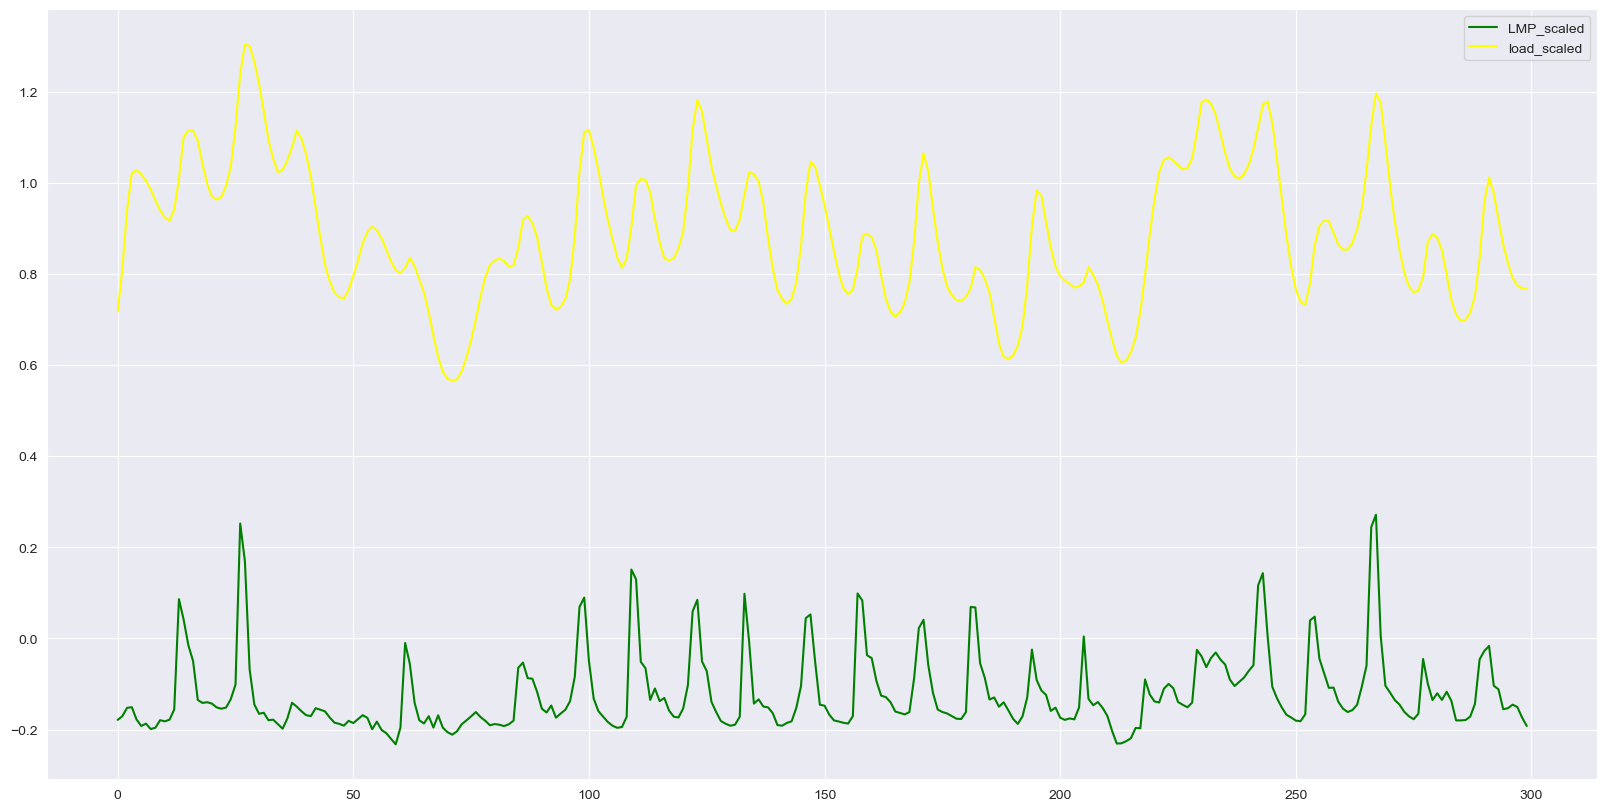

In [69]:
# plot
fig, ax = plt.subplots(figsize=(20, 10))

x = df_lmp_filtered['DeliveryTime_adjusted'][df_lmp_filtered['SUBSTATION'] == '89NWK'].values[100:400]
y1 = df_lmp_filtered['LMP_scaled'][df_lmp_filtered['SUBSTATION'] == '89NWK'].values[100:400]
y2 = df_lmp_filtered['load_scaled'][df_lmp_filtered['SUBSTATION'] == '89NWK'].values[100:400]

# y2 -= 1

ax.plot(y1, color='green', label='LMP_scaled')
ax.plot(y2, color='yellow', label = 'load_scaled')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# takes 7 min
# s1 = set(pd.date_range(
#     df_lmp_filtered['DeliveryTime_adjusted'].min(), 
#     df_lmp_filtered['DeliveryTime_adjusted'].max(), 
#     freq='h'))
# s2 = set(df_lmp_filtered['DeliveryTime_adjusted'])
# len(s1), len(s2), len(s1.intersection(s2))

In [17]:
s7 = set(pd.date_range(
    df_dsp_filtered['DeliveryTime_adjusted'].min(), 
    df_dsp_filtered['DeliveryTime_adjusted'].max(), 
    freq='h'))
s8 = set(df_dsp_filtered['DeliveryTime_adjusted'])
len(s7), len(s8), len(s7.intersection(s8)), len(s7.difference(s8)), #len(s2.difference(s8))

(25680, 25665, 25665, 15)

In [18]:
(df_lmp_filtered['DeliveryTime_adjusted'].min(), df_lmp_filtered['DeliveryTime_adjusted'].max(), 
 df_dsp_filtered['DeliveryTime_adjusted'].min(), df_dsp_filtered['DeliveryTime_adjusted'].max())

(Timestamp('2022-01-02 01:00:00'),
 Timestamp('2024-12-07 00:00:00'),
 Timestamp('2022-01-02 01:00:00'),
 Timestamp('2024-12-07 00:00:00'))

In [19]:
s13 = set(df_dsp_filtered['FromStation_index_2'])
s14 = set(df_dsp_filtered['ToStation_index_2'])
s15 = set(df_lmp_filtered['SUBSTATION_index_2'])
len(s13), len(s14), len(s15), len(s13.difference(s15)), len(s14.difference(s15))

(479, 542, 3548, 0, 0)

In [211]:
###########################
# Array prep
###########################

load_zones = OneHotEncoder().fit_transform(
    df_lmp_filtered['SETTLEMENT_LOAD_ZONE_index'].values.reshape(-1, 1)
).toarray().astype(np.int64)

# hr_of_day = OneHotEncoder().fit_transform(
#     df_lmp_filtered['DeliveryTime_adjusted'].dt.hour.values.reshape(-1, 1)
# ).toarray().astype(np.int64)
hr_of_day = df_lmp_filtered['DeliveryTime_adjusted'].dt.hour.values.reshape(-1, 1).astype(np.int64)

df_lmp_filtered['LMP_scaled_2'] = StandardScaler().fit_transform(df_lmp_filtered[['LMP']])
df_lmp_filtered['load_scaled_2'] = StandardScaler().fit_transform(df_lmp_filtered[['load']])  # TODo must scale only the dataset used for training not all!

array = np.concatenate([df_lmp_filtered[['LMP_scaled_2', 'load_scaled_2']].values, hr_of_day], axis=1)



node_feat_count = array.shape[1]  # 30
node_count = len(set_lmp)  # 3548

array_reshaped = array.reshape(-1, node_count, node_feat_count)
array.shape, '->', array_reshaped.shape, node_feat_count, node_count

((91112640, 3), '->', (25680, 3548, 3), 3, 3548)

In [322]:
def extract_dynamic_edges(hr, _node_count):
    # df_hr = df_dsp_filtered[df_dsp_filtered['DeliveryTime_adjusted'] == hr]
    # 
    # df_hr = df_hr[df_hr['FromStation_index_2'].isin(list(range(_node_count))) & df_hr['ToStation_index_2'].isin(list(range(_node_count)))]  # TODO
    # 
    # if len(df_hr):
    #     cols = ['FromStation_index_2', 'ToStation_index_2']
    #     indexes = df_hr[cols].values.transpose()  # [2 x num_edges]
    #     cols = ['ConstraintValue_scaled', 'kV_scaled', 'ShadowPrice_scaled']
    #     feats = df_hr[cols].values#.transpose()    # [num_edges x num_features]
    #     return indexes, feats
    # else:
    #     return extract_dynamic_edges('2024-10-16 01:00:00', _node_count)  # impute 15 records
    return np.array([[55],[55]]), np.array([[-0.532385], [-0.938807], [-0.240247]]).T

In [324]:
_node_count = 5

xs = []
edge_indices = []
ys = []
edge_features = []
# batches = []

sequence_len = 24
prediction_len = 12

hours = pd.date_range(lmp_dt_min, lmp_dt_max, freq='h')
seq_length = len(hours) - int(sequence_len + prediction_len - 1)

for i in range(seq_length):

    prev_hrs = array_reshaped[i:i+sequence_len,:_node_count,:]
    curr_hr = array_reshaped[i+sequence_len:i+sequence_len+prediction_len,:_node_count,:]

    edge_index, edge_feat = extract_dynamic_edges(hours[i], _node_count)
    y = curr_hr.transpose((1, 2, 0))[:,0,:]

    xs.append(prev_hrs.transpose((1, 2, 0)))
    edge_indices.append(edge_index) 
    
    edge_features.append(edge_feat) 
    ys.append(y)

    # batches.append(np.repeat(i, node_count))

In [325]:
i = 55
print(f"""i:        {i} of {len(xs)}:
Node feature shape: {xs[i].shape}
Edge index shape:   {edge_indices[i].shape}
Edge feature shape: {edge_features[i].shape}
Labels shape:       {ys[i].shape}

""") # Batches shape:      {batches[i].shape}

len(xs), len(edge_indices), len(edge_features), len(ys), seq_length

i:        55 of 25645:
Node feature shape: (5, 3, 24)
Edge index shape:   (2, 1)
Edge feature shape: (1, 3)
Labels shape:       (5, 12)




(25645, 25645, 25645, 25645, 25645)

In [338]:
cutoff = 5000
# DynamicGraphTemporalSignalBatch
dataset = DynamicGraphTemporalSignal(
    edge_indices=edge_indices[:cutoff], 
    edge_weights=edge_features[:cutoff], 
    features=xs[:cutoff], 
    targets=ys[:cutoff],
    # batches=batches[:cutoff]
)

train_ratio = 0.8
train_slice = slice(None, int(train_ratio * dataset.snapshot_count))
test_slice = slice(int(train_ratio * dataset.snapshot_count), None)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)

print(f'{dataset.snapshot_count} -> {train_dataset.snapshot_count}, {test_dataset.snapshot_count}'
      f'\ntrain_slice: {train_slice}, test_slice: {test_slice}')

train_loader, test_loader = train_dataset, test_dataset

5000 -> 4000, 1000
train_slice: slice(None, 4000, None), test_slice: slice(4000, None, None)


In [23]:
# folder = Path(r'/Users/koraykinik/Library/CloudStorage/GoogleDrive-koraykinik1984@gmail.com/My Drive/np_dataset')
# for i in range(seq_length):
#     fp = folder / f'arr_{i}.npz'
#     if fp.exists():
#         ...
#     else:
#         np.savez_compressed(folder / f'arr_{str(i).zfill(6)}.npz', 
#                         xs=xs[i], 
#                         edge_indices=edge_indices[i], 
#                         edge_features=edge_features[i], 
#                         ys=ys[i], 
#                         batches=batches[i])

# np.load(folder / f'arr_{i}.npz')['xs'].shape 

In [24]:
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# 
# class MyOwnDataset:
#     
#     def __init__(self, npz_files):
#         self.files = npz_files
#         self.snapshot_count = len(npz_files)
#         
#     def __getitem__(self, i):
# 
#         arr = np.load(self.files[i])
# 
#         return Data(
#             x=torch.FloatTensor(arr['xs']), 
#             edge_index=torch.LongTensor(arr['edge_indices']), 
#             edge_attr=torch.FloatTensor(arr['edge_features']), 
#             y=torch.FloatTensor(arr['ys'])
#         )
#     
#     def __len__(self):
#         return self.snapshot_count
#     
#     def __next__(self):
#         if self.t < self.snapshot_count:
#             _snapshot = self[self.t]
#             self.t = self.t + 1
#             return _snapshot
#         else:
#             self.t = 0
#             raise StopIteration
# 
#     def __iter__(self):
#         self.t = 0
#         return self
#     
# folder = Path(r'/Users/koraykinik/Library/CloudStorage/GoogleDrive-koraykinik1984@gmail.com/My Drive/np_dataset')
# files = Path(folder).rglob('*.npz')
# files = sorted(files, key=lambda fn: int(Path(fn).stem.split('arr_')[1]))
# 
# cutoff = 300
# files = files[:cutoff]
# 
# train_ratio = 0.8
# train_slice = slice(None, int(train_ratio * len(files)))
# test_slice = slice(int(train_ratio * len(files)), None)
# 
# train_dataset = MyOwnDataset(files[train_slice])
# test_dataset = MyOwnDataset(files[test_slice])
# # entire numpy data (excluding batches arg), is 65 GB on disk, 40GB in memory.
# train_dataset.snapshot_count, test_dataset.snapshot_count

In [203]:
# batch_size = 8
# 
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# 
# len(train_loader), len(test_loader)

In [26]:
# node_feat_count = 30
# node_count = 3548
# sequence_len = 48
# prediction_len = 12

In [343]:
device = torch.device("cpu") 
# device = torch.device("mps") 
# device = torch.device("cuda")
print(device.type)

# benedekrozemberczki/pytorch_geometric_temporal: PyTorch Geometric Temporal: Spatiotemporal Signal Processing with Neural Machine Learning Models (CIKM 2021)
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/resources.html

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()

        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=256,
                           periods=periods)
        # Equals single-shot prediction
        self.linear1 = torch.nn.Linear(256, periods)
        self.linear2 = torch.nn.Linear(periods, 128)
        self.linear3 = torch.nn.Linear(128, periods)
        self.linear4 = torch.nn.Linear(periods, 32)
        self.linear5 = torch.nn.Linear(32, periods)

    def forward(self, _x, _edge_index):
        """
        _x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(_x, _edge_index)
        h = F.relu(h)
        h = self.linear1(h)
        h = self.linear2(h)
        h = self.linear3(h)
        h = self.linear4(h)
        h = self.linear5(h)

        return h


cpu


In [340]:
torch.mps.empty_cache()

In [344]:
model = TemporalGNN(node_features=node_feat_count, periods=prediction_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
scaler = torch.amp.GradScaler()

train_losses = []
epochs = 100
step = 0

train_labels = []
train_predictions = []

for epoch in range(epochs):
    t1 = time.time()
    loss = 0
    for step, snapshot in enumerate(train_loader):
        snapshot = snapshot.to(device)
        
        with torch.autocast(device.type):
            y_hat = model(snapshot.x, snapshot.edge_index)
            loss += torch.mean((y_hat-snapshot.y)**2)
            
        # record the last train labels for plotting
        if epoch == epochs - 1:
            train_labels.append(snapshot.y)
            train_predictions.append(y_hat)
    
    loss = loss / (step + 1)        
    scaler.scale(loss).backward()
    
    scaler.step(optimizer)
    optimizer.zero_grad()
    scaler.update()
    train_losses.append(loss.item())
    print(f'{epoch+1}/{epochs}, MSE:{sum(train_losses)/len(train_losses):.4f}, {(time.time()-t1)/60:.2f} min')

ts = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
torch.save(model, f'model_{ts}.pth') 

/Users/koraykinik/miniconda3/envs/ercot/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


1/100, MSE:0.2014, 2.37 min
2/100, MSE:0.1986, 2.19 min
3/100, MSE:0.1967, 2.14 min
4/100, MSE:0.1952, 2.13 min
5/100, MSE:0.1941, 2.21 min
6/100, MSE:0.1932, 2.10 min
7/100, MSE:0.1925, 2.09 min
8/100, MSE:0.1920, 2.16 min
9/100, MSE:0.1916, 2.13 min
10/100, MSE:0.1912, 2.13 min
11/100, MSE:0.1910, 2.10 min
12/100, MSE:0.1907, 2.09 min
13/100, MSE:0.1904, 2.14 min
14/100, MSE:0.1902, 2.09 min
15/100, MSE:0.1900, 2.10 min
16/100, MSE:0.1898, 2.11 min
17/100, MSE:0.1896, 2.13 min
18/100, MSE:0.1894, 2.17 min
19/100, MSE:0.1893, 2.14 min
20/100, MSE:0.1891, 2.19 min
21/100, MSE:0.1889, 2.13 min
22/100, MSE:0.1887, 2.11 min
23/100, MSE:0.1885, 2.06 min
24/100, MSE:0.1883, 2.09 min
25/100, MSE:0.1881, 2.09 min
26/100, MSE:0.1879, 2.11 min
27/100, MSE:0.1876, 2.10 min
28/100, MSE:0.1873, 2.08 min
29/100, MSE:0.1870, 2.08 min
30/100, MSE:0.1867, 2.09 min
31/100, MSE:0.1863, 2.07 min
32/100, MSE:0.1859, 2.11 min
33/100, MSE:0.1855, 2.08 min
34/100, MSE:0.1851, 2.12 min
35/100, MSE:0.1847, 2.1

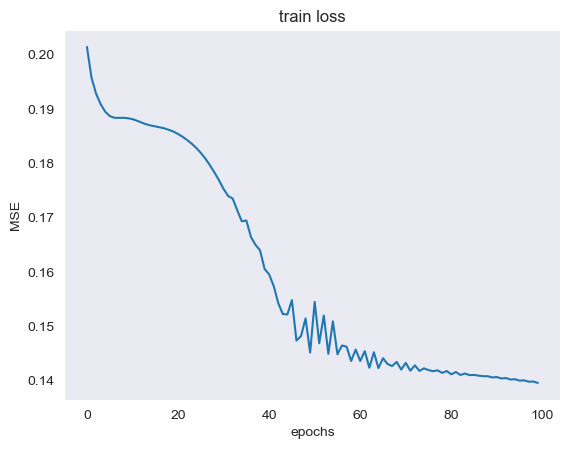

In [345]:
plt.plot(train_losses)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.grid()
plt.title('train loss')
plt.show()

In [346]:
model.eval()
loss = 0
step = 0

predictions = []
labels = []

test_losses = []

for snapshot in test_loader:
    snapshot = snapshot.to(device)

    with torch.autocast(device.type):
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss += torch.mean((y_hat-snapshot.y)**2)
        
    test_losses += [loss.item()]

    labels.append(snapshot.y)
    predictions.append(y_hat)

print('eval shapes', predictions[0].shape, labels[0].shape, len(predictions), len(labels))

eval shapes torch.Size([5, 12]) torch.Size([5, 12]) 1000 1000


In [347]:
len_train, len_test = train_dataset.snapshot_count, test_dataset.snapshot_count
###find the best looking node to plot:
labs = np.asarray([l.detach().cpu().float().numpy() for l in labels]).reshape(-1, len_test).reshape(-1, _node_count, prediction_len)[:,:,0]
preds = np.asarray([p.detach().cpu().float().numpy() for p in predictions])
preds = preds.reshape(-1, len_test).reshape(-1, _node_count, prediction_len)[:,:,0]
MSEs = np.sum(((labs-preds)*2), axis=0)
np.argmin(MSEs, axis=0)

2

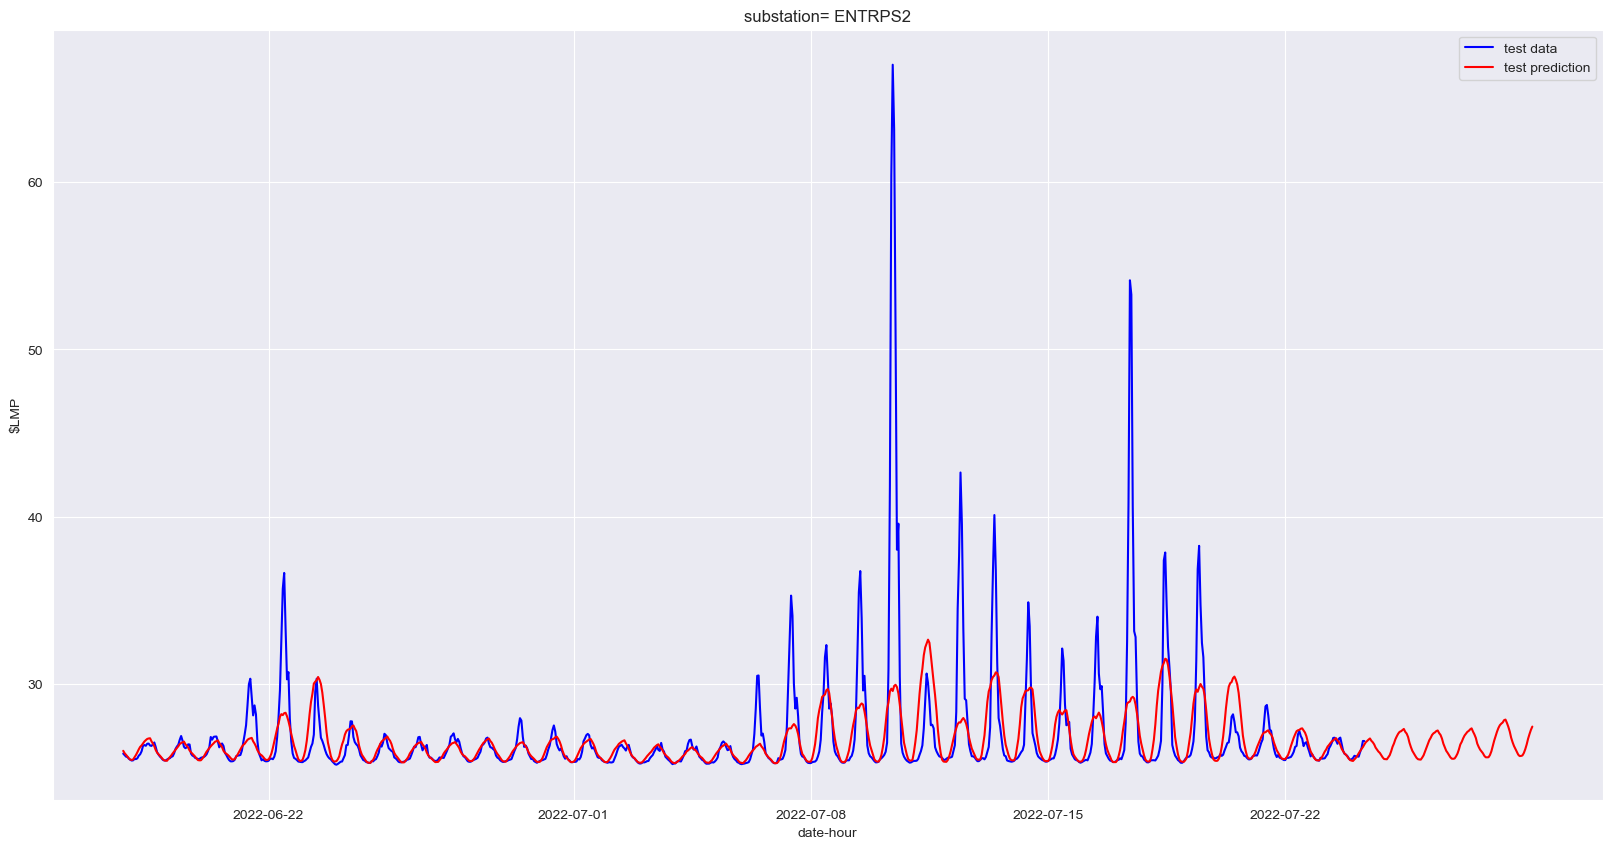

(25.021816, 30.22157, 25.69886) (24.459673, 48.204823, 25.670923)


In [374]:
node = 2
timestep = 5

# len_train, len_test = train_dataset.snapshot_count, test_dataset.snapshot_count
# len_train, len_test = len(train_loader), len(test_loader)


# y_hats vs actual labels of test data
labs =  np.asarray([l.detach().cpu().float().numpy() for l in labels])
preds = np.asarray([p.detach().cpu().float().numpy() for p in predictions])
labs =   labs.reshape(-1, len_test).reshape(-1, _node_count, prediction_len)[:,node,timestep]
preds = preds.reshape(-1, len_test).reshape(-1, _node_count, prediction_len)[:,node,timestep]
# labs =   labs.reshape(-1, len_test).reshape(-1, node_count, prediction_len)[:,:,timestep].mean(axis=1)
# preds = preds.reshape(-1, len_test).reshape(-1, node_count, prediction_len)[:,:,timestep].mean(axis=1)

train_labs = np.asarray([l.detach().cpu().float().numpy() for l in train_labels])
train_preds = np.asarray(np.asarray([p.detach().cpu().float().numpy() for p in train_predictions]))
train_labs =   train_labs.reshape(-1, len_train).reshape(-1, _node_count, prediction_len)[:,node,timestep]
train_preds = train_preds.reshape(-1, len_train).reshape(-1, _node_count, prediction_len)[:,node,timestep]
# train_labs =   train_labs.reshape(-1, len_train).reshape(-1, node_count, prediction_len)[:,:,timestep].mean(axis=1)
# train_preds = train_preds.reshape(-1, len_train).reshape(-1, node_count, prediction_len)[:,:,timestep].mean(axis=1)

hours = pd.date_range('2022-01-02 01:00:00', '2024-12-07 00:00:00', freq='h')[:cutoff]
train_hours = hours[train_slice]
test_hours = hours[test_slice][:len(preds)]

# # # unscale
mean = df_lmp_filtered['LMP'][:dataset.snapshot_count].mean()
std = df_lmp_filtered['LMP'][:dataset.snapshot_count].std()
# print(f'len {dataset.snapshot_count}, mean {mean:.2f}, std {std:.6f}')

labs_arr = labs * std + mean
preds_arr = preds * std + mean

train_labs_arr = train_labs * std + mean
train_preds_arr = train_preds * std + mean

# plot
fig, ax = plt.subplots(figsize=(20, 10))

# train_labs_arr += 1  # TODO
# train_labs_arr = np.roll(train_labs_arr, 3)  # TODO

c = -1
# ax.plot(train_hours[:c], train_labs_arr[:c], color='green', label='train data')
# ax.plot(train_hours[:c], train_preds_arr[:c], color='yellow', label = 'train fit')

ax.plot(test_hours[:-120], labs_arr[:-120], color='blue', label='test data')
ax.plot(test_hours[:c], preds_arr[:c], color='red', label = 'test prediction')

plt.grid(True)
# plt.title(f'train {len(train_hours)} hours, test {len(test_hours)} hours')
plt.title(f'substation= ENTRPS2')
plt.xlabel('date-hour')
plt.ylabel('$LMP')
plt.legend()
# plt.ylim(25, 40)

ts = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
# plt.savefig(f'./results_{ts}.png')
plt.show()

print((train_preds_arr.min(), train_preds_arr.max(), train_preds_arr.mean()), (train_labs_arr.min(), train_labs_arr.max(), train_labs_arr.mean()))

In [ ]:
train_labs_arr